# Import

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score


## From here it's workable

In [28]:
def assign_scores(row):
    if row['booking_bool'] == 1:
        return 5
    elif row['click_bool'] == 1:
        return 1
    else:
        return 0

In [29]:
# 逐个读取feature_engineered_training_chunk{i}并上下拼接到一个df
base_path = '/Users/Priyank/Desktop/dmt2/feature_engineered_train/'
file_pattern = 'feature_engineered_training_chunk_{}.csv'
for i in range(10):
    df_chunk = pd.read_csv(base_path + file_pattern.format(i))
    df_chunk['score'] = df_chunk.apply(assign_scores, axis=1)
    if i == 0:
        df = df_chunk
    else:
        df = pd.concat([df, df_chunk], axis=0)
df.head()


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp1_rate_percent_diff_prop_id_mean,comp1_rate_percent_diff_prop_id_median,comp2_rate_percent_diff_prop_id_mean,comp2_rate_percent_diff_prop_id_median,people_per_room,people_location_interaction,hist_price_interaction,rating_review_interaction,price_location_ratio,score
0,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,893,3,3.5,...,0.0,0.0,0.438965,0.0,4.0,11.32,0.0,10.5,37.021201,0
1,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,10404,4,4.0,...,0.0,0.0,0.000000,0.0,4.0,8.80,0.0,16.0,77.609091,0
2,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,21315,3,4.5,...,0.0,0.0,1.130790,0.0,4.0,8.80,0.0,13.5,81.727273,0
3,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,27348,2,4.0,...,0.0,0.0,7.386609,5.0,4.0,11.32,0.0,8.0,171.321555,0
4,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,29604,4,3.5,...,0.0,0.0,0.517216,0.0,4.0,10.56,0.0,14.0,54.386364,0


In [30]:
# 检查df NA 展示有NA的列
na_counts = df.isna().sum()

# 打印有NA值的列和NA值的数量
print("Columns with NA values and their counts:")
for col, count in na_counts.items():
    if count > 0:
        print(f"{col}: {count}")
# 删除有NA值的列
df = df.dropna(axis=1)


Columns with NA values and their counts:
hist_price_interaction: 31
price_location_ratio: 2


In [31]:
columns = df.columns

# 使用列表推导式筛选出不需要删除的列
features = [
    col for col in columns if col not in ['date_time', 'position', 'click_bool', 'booking_bool', 'score']
    and 'gross_bookings_usd' not in col and 'position' not in col
]


print(len(features))
print(len(df.columns))

71
79


In [32]:
print(features)

['srch_id', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'bool_visitor_hist', 'visitor_hist_starrating_prop_id_mean', 'visitor_hist_starrating_prop_id_median', 'visitor_hist_adr_usd_prop_id_mean', 'visitor_hist_adr_usd_prop_id_median', 'prop_starrating_prop_id_mean', 'prop_starrating_prop_id_median', 'prop_review_score_prop_id_mean', 'prop_review_score_prop_id_median', 'prop_location_

### Default Params

In [7]:
default_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'max_depth': 3,
    'num_leaves': 28,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'min_child_samples': 40,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'cat_smooth': 0,
    'num_iterations': 800,
    'is_unbalance': True  # 仅当你确信数据不平衡严重且影响模型性能时才设置
}

In [34]:
pd.options.mode.chained_assignment = None  # default='warn'

In [35]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import random

unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, shuffle=True)  # 首先分割出20%为最终测试集
train_val_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42, shuffle=True)  # 将剩余80%分为训练集(60%)和验证集(20%)

train_df = df[df['srch_id'].isin(train_val_ids)]
val_df = df[df['srch_id'].isin(val_ids)]
test_df = df[df['srch_id'].isin(test_ids)]

train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
val_data = lgb.Dataset(val_df[features], label=val_df['score'], group=val_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

# 参数空间
# param_grid = {
#     'num_leaves': [10, 31, 50, 70],
#     'max_depth': [3, 5, 6, 8],
#     'min_child_samples': [10, 20, 30, 40],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'feature_fraction': [0.6, 0.7, 0.8, 0.9],
#     'bagging_fraction': [0.6, 0.7, 0.8, 0.9],
#     'bagging_freq': [1, 2, 4],
#     'reg_alpha': [0, 0.001, 0.01, 0.1],
#     'reg_lambda': [0, 1, 5, 10]
# }

# # 随机搜索
# best_ndcg = 0
# best_params = None
# n_iterations = 50  # 定义迭代次数

param_grid = {
    'num_leaves': [70, 90, 125, 150, 200],
    'max_depth': [6, 8, 12, 20, 40],
    'min_child_samples': [10, 20, 30, 40, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.025],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9],
    'bagging_freq': [1, 2, 4],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0, 1, 5, 10]
}

# 随机搜索最佳参数
best_ndcg = 0
best_params = None
n_iterations = 50

for _ in range(n_iterations):
    random_params = {k: random.choice(v) for k, v in param_grid.items()}
    random_params.update({'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5], 'verbose': -1, 
                          'boosting_type': 'gbdt', 'num_iterations': 150, 'feature_pre_filter': False})

    bst = lgb.train(
        random_params,
        train_data,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(15)]
    )

    test_pred = bst.predict(test_df[features], num_iteration=bst.best_iteration)
    test_df['predictions'] = test_pred
    test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)
    grouped = test_df.groupby('srch_id')
    ndcg_scores = []

    for name, group in grouped:
        true_relevance = group['score'].values
        scores_pred = group['predictions'].values
        if len(np.unique(true_relevance)) > 1:
            ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

    average_ndcg = np.mean(ndcg_scores)
    print(f"Average NDCG Score: {average_ndcg}")
    if average_ndcg > best_ndcg:
        best_ndcg = average_ndcg
        best_params = random_params

print(f"Best NDCG Score: {best_ndcg}")
print("Best Parameters:", best_params)

/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's ndcg@3: 0.331435	valid_0's ndcg@5: 0.387004
Average NDCG Score: 0.3869575804376442


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.340122	valid_0's ndcg@5: 0.396885
Average NDCG Score: 0.39827022948450325


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.329112	valid_0's ndcg@5: 0.385694
Average NDCG Score: 0.38603443609327437


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[50]	valid_0's ndcg@3: 0.323105	valid_0's ndcg@5: 0.379813
Average NDCG Score: 0.377601902712018


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.334703	valid_0's ndcg@5: 0.390732
Average NDCG Score: 0.3908056970988819


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's ndcg@3: 0.331226	valid_0's ndcg@5: 0.38716
Average NDCG Score: 0.38569689231164533


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.332221	valid_0's ndcg@5: 0.388415
Average NDCG Score: 0.3883296042651558


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[135]	valid_0's ndcg@3: 0.340146	valid_0's ndcg@5: 0.396197
Average NDCG Score: 0.39736742505290634


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[70]	valid_0's ndcg@3: 0.336612	valid_0's ndcg@5: 0.393264
Average NDCG Score: 0.39193047345374


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[38]	valid_0's ndcg@3: 0.320515	valid_0's ndcg@5: 0.376612
Average NDCG Score: 0.3783486222903136


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[38]	valid_0's ndcg@3: 0.326036	valid_0's ndcg@5: 0.382666
Average NDCG Score: 0.3820449419707043


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[41]	valid_0's ndcg@3: 0.320218	valid_0's ndcg@5: 0.376486
Average NDCG Score: 0.37504295944132254


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[133]	valid_0's ndcg@3: 0.338411	valid_0's ndcg@5: 0.395632
Average NDCG Score: 0.39572388142407805


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.33914	valid_0's ndcg@5: 0.396335
Average NDCG Score: 0.39612651022786444


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.343173	valid_0's ndcg@5: 0.399796
Average NDCG Score: 0.3996475919168145


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@3: 0.322386	valid_0's ndcg@5: 0.378605
Average NDCG Score: 0.3792093508213148


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[145]	valid_0's ndcg@3: 0.332612	valid_0's ndcg@5: 0.389401
Average NDCG Score: 0.38858277768521277


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[134]	valid_0's ndcg@3: 0.324599	valid_0's ndcg@5: 0.380414
Average NDCG Score: 0.38165565107061483


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[63]	valid_0's ndcg@3: 0.326181	valid_0's ndcg@5: 0.382748
Average NDCG Score: 0.3812558577936653


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.336115	valid_0's ndcg@5: 0.393005
Average NDCG Score: 0.392910901228216


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.337717	valid_0's ndcg@5: 0.395058
Average NDCG Score: 0.39535753773180426


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[146]	valid_0's ndcg@3: 0.336453	valid_0's ndcg@5: 0.391561
Average NDCG Score: 0.3920374079482647


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[101]	valid_0's ndcg@3: 0.3382	valid_0's ndcg@5: 0.39469
Average NDCG Score: 0.3919076779225956


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[36]	valid_0's ndcg@3: 0.327521	valid_0's ndcg@5: 0.384439
Average NDCG Score: 0.3833320469160828


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[94]	valid_0's ndcg@3: 0.336525	valid_0's ndcg@5: 0.393325
Average NDCG Score: 0.3925228222942812


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.335262	valid_0's ndcg@5: 0.392097
Average NDCG Score: 0.3917461611663761


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@3: 0.325097	valid_0's ndcg@5: 0.381531
Average NDCG Score: 0.3812086877032569


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[84]	valid_0's ndcg@3: 0.335134	valid_0's ndcg@5: 0.392182
Average NDCG Score: 0.3920140716298534


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[145]	valid_0's ndcg@3: 0.33268	valid_0's ndcg@5: 0.389859
Average NDCG Score: 0.38927801084291114


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[42]	valid_0's ndcg@3: 0.315626	valid_0's ndcg@5: 0.372186
Average NDCG Score: 0.37281854911472856


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's ndcg@3: 0.32407	valid_0's ndcg@5: 0.380188
Average NDCG Score: 0.3806906908311462


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.341394	valid_0's ndcg@5: 0.39767
Average NDCG Score: 0.39711370607280355


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's ndcg@3: 0.332078	valid_0's ndcg@5: 0.388099
Average NDCG Score: 0.38940155775878743


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[31]	valid_0's ndcg@3: 0.323201	valid_0's ndcg@5: 0.380558
Average NDCG Score: 0.38156256479039263


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.331713	valid_0's ndcg@5: 0.388213
Average NDCG Score: 0.38966410312676025


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.341359	valid_0's ndcg@5: 0.397947
Average NDCG Score: 0.3982236029865754


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[144]	valid_0's ndcg@3: 0.338154	valid_0's ndcg@5: 0.393883
Average NDCG Score: 0.39448949343270545


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[110]	valid_0's ndcg@3: 0.33713	valid_0's ndcg@5: 0.394021
Average NDCG Score: 0.3945035702533743


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@3: 0.323079	valid_0's ndcg@5: 0.380975
Average NDCG Score: 0.3798209920776448


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@3: 0.329074	valid_0's ndcg@5: 0.385637
Average NDCG Score: 0.38602320567195425


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[80]	valid_0's ndcg@3: 0.335358	valid_0's ndcg@5: 0.391706
Average NDCG Score: 0.39058075572800105


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.335017	valid_0's ndcg@5: 0.39097
Average NDCG Score: 0.3912598323537792


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[125]	valid_0's ndcg@3: 0.339126	valid_0's ndcg@5: 0.39613
Average NDCG Score: 0.3964660277340892


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[81]	valid_0's ndcg@3: 0.331164	valid_0's ndcg@5: 0.388301
Average NDCG Score: 0.3876063175892117


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's ndcg@3: 0.337482	valid_0's ndcg@5: 0.393888
Average NDCG Score: 0.39409897576764746


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[132]	valid_0's ndcg@3: 0.339294	valid_0's ndcg@5: 0.395288
Average NDCG Score: 0.3960197926982445


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's ndcg@3: 0.326261	valid_0's ndcg@5: 0.383252
Average NDCG Score: 0.38203560745413406


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[73]	valid_0's ndcg@3: 0.321152	valid_0's ndcg@5: 0.376508
Average NDCG Score: 0.37510135211965007


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[23]	valid_0's ndcg@3: 0.316041	valid_0's ndcg@5: 0.372014
Average NDCG Score: 0.3725254091507669


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[75]	valid_0's ndcg@3: 0.33634	valid_0's ndcg@5: 0.392602
Average NDCG Score: 0.3907592655076022
Best NDCG Score: 0.3996475919168145
Best Parameters: {'num_leaves': 150, 'max_depth': 20, 'min_child_samples': 30, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'reg_alpha': 0.1, 'reg_lambda': 10, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5], 'verbose': -1, 'boosting_type': 'gbdt', 'num_iterations': 150, 'feature_pre_filter': False}


### Validation Result Documentation

In [36]:
unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, shuffle=True)
train_df = df[df['srch_id'].isin(train_val_ids)]
test_df = df[df['srch_id'].isin(test_ids)]


# 准备 LightGBM 数据结构
train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

# 设置模型参数
params = {'num_leaves': 150, 'max_depth': 20, 'min_child_samples': 30, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'reg_alpha': 0.1, 'reg_lambda': 10, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5], 'verbose': -1, 'boosting_type': 'gbdt', 'num_iterations': 150, 'feature_pre_filter': False}
num_round = 250
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# 预测测试集
test_pred = bst.predict(test_df[features])

# 评估模型，计算 NDCG 分数
test_df['predictions'] = test_pred

# 首先确保数据按照 srch_id 和 predictions 降序排序
test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 分组并计算每个搜索会话的 NDCG
grouped = test_df.groupby('srch_id')
ndcg_scores = []

for name, group in grouped:
    group = group.sort_values('predictions', ascending=False)
    true_relevance = group['score'].values
    scores_pred = group['predictions'].values
    # 计算当前搜索会话的 NDCG 分数，并追加到列表中
    if len(np.unique(true_relevance)) > 1:  # 只计算有正样本的会话
        ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG Score: {average_ndcg}")


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Average NDCG Score: 0.3996475919168145


# Feature importance

In [37]:
# Feature importance based on split count
importances_split = bst.feature_importance(importance_type='split')
# Feature importance based on gain
importances_gain = bst.feature_importance(importance_type='gain')

# Get feature names
feature_names = train_df[features].columns.tolist()

# Create a DataFrame to display importance
importance_df_split = pd.DataFrame({'Feature': feature_names, 'Importance (Split)': importances_split})
importance_df_gain = pd.DataFrame({'Feature': feature_names, 'Importance (Gain)': importances_gain})

# Sort the data for better visualization
importance_df_split.sort_values(by='Importance (Split)', ascending=False, inplace=True)
importance_df_gain.sort_values(by='Importance (Gain)', ascending=False, inplace=True)


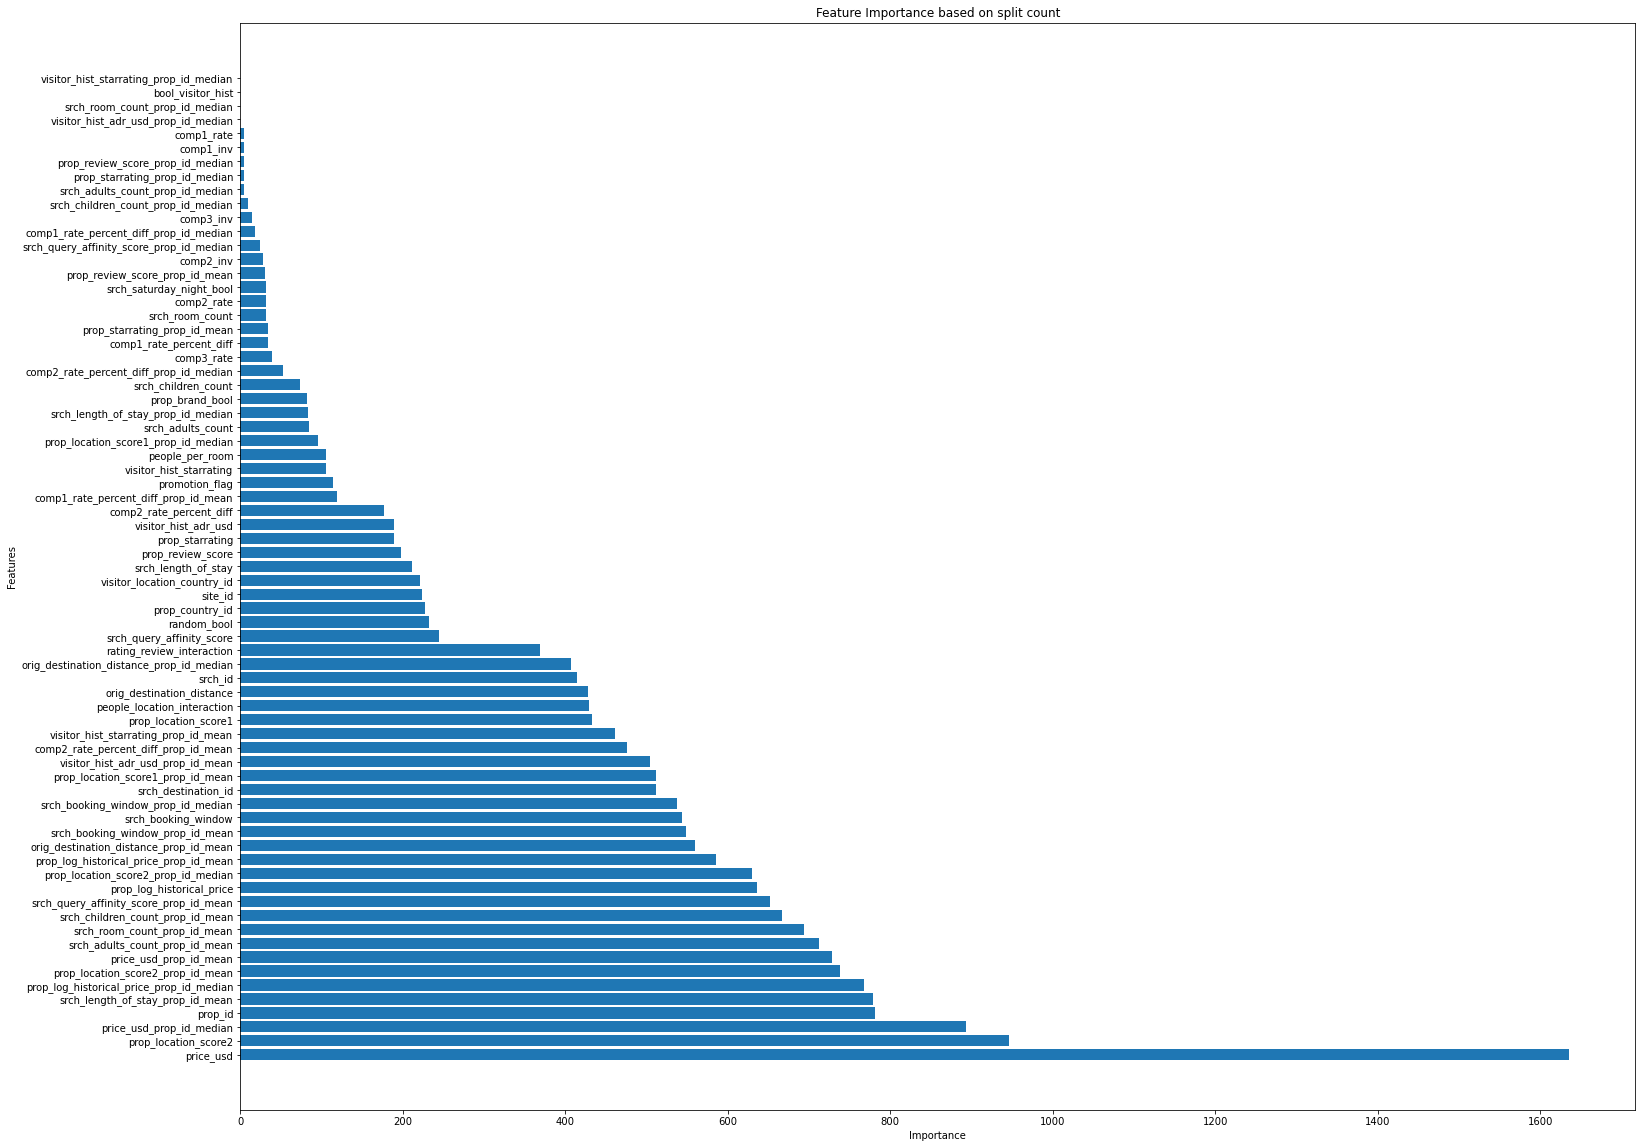

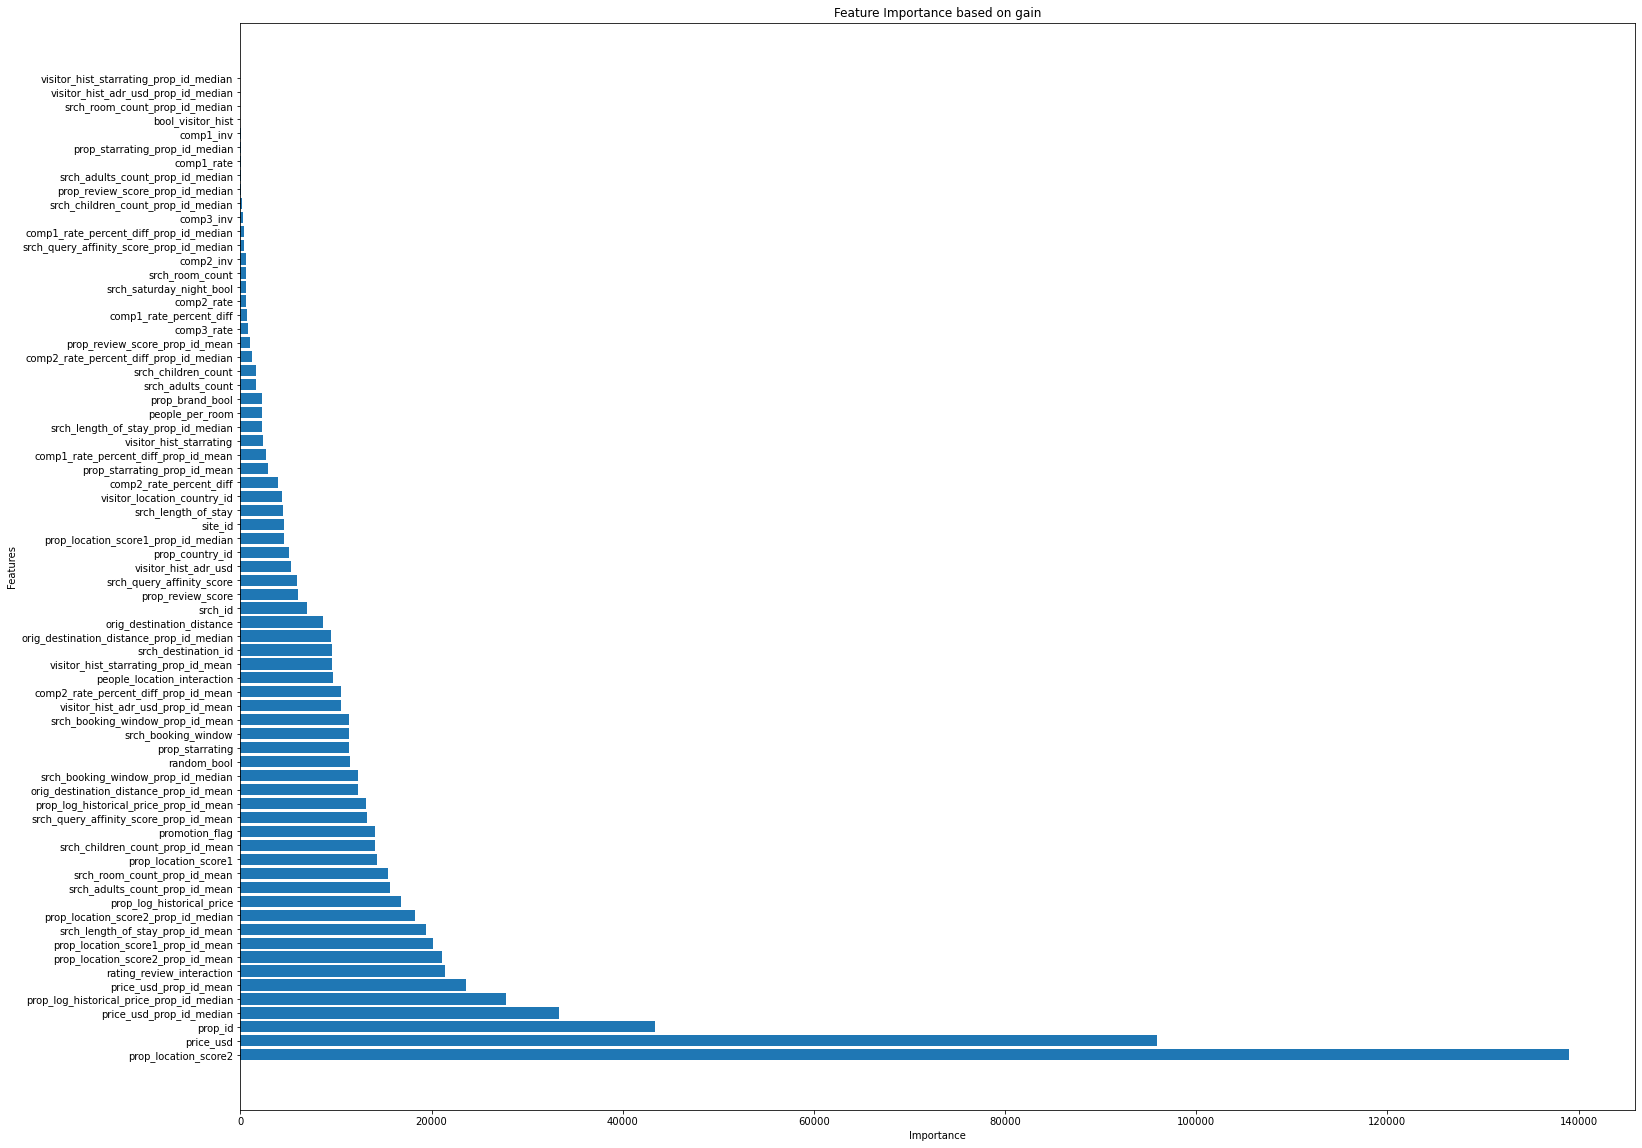

In [38]:
# Plotting feature importance - Split
plt.figure(figsize=(25, 20))
plt.title('Feature Importance based on split count')
plt.barh(importance_df_split['Feature'], importance_df_split['Importance (Split)'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Plotting feature importance - Gain
plt.figure(figsize=(25, 20))
plt.title('Feature Importance based on gain')
plt.barh(importance_df_gain['Feature'], importance_df_gain['Importance (Gain)'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


### Result output

In [39]:
# 使用迭代器逐块读取数据
chunk_size = 10000
reader = pd.read_csv('/Users/Priyank/Desktop/dmt2/feature_engineered_test_set_VU_DM.csv', chunksize=chunk_size)

predictions = []  # 创建一个空列表以存储每个块的预测结果
for chunk in reader:
    # 可以在这里添加数据预处理步骤，比如填充缺失值等
    chunk_pred = bst.predict(chunk[features])  # 应用模型进行预测
    chunk['predictions'] = chunk_pred  # 将预测结果添加到 DataFrame
    predictions.append(chunk[['srch_id', 'prop_id', 'predictions']])  # 仅保留需要的列

# 合并所有批次的预测结果
final_predictions = pd.concat(predictions)

In [40]:
# 确保按照预测分数排序，如果 Kaggle 要求
final_predictions.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 选择需要的列
final_predictions = final_predictions[['srch_id', 'prop_id']]

# 保存为 CSV 文件，确保不包含索引，包含列标题
final_predictions.to_csv('updated_params.csv', index=False, header=True)

In [15]:
print(final_predictions)

         srch_id  prop_id
23             1    99484
9              1    54937
12             1    61934
5              1    28181
6              1    34263
...          ...      ...
4959177   332787    29018
4959182   332787    99509
4959181   332787    94437
4959178   332787    32019
4959180   332787    35240

[4959183 rows x 2 columns]


# Feature importance

In [41]:
importance = bst.feature_importance(importance_type='gain')
features = [feat for feat, imp in zip(features, importance) if imp > 75] 

In [42]:
# Prepare data structures with filtered features
train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

# Model parameters
params = {
    'num_leaves': 90,
    'max_depth': 40,
    'min_child_samples': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [3, 5],
    'verbose': -1,
    'boosting_type': 'gbdt',
    'num_iterations': 150,
    'feature_pre_filter': False
}

# Retrain the model with selected features
bst = lgb.train(params, train_data, valid_sets=[test_data])

# Predict and evaluate
test_pred = bst.predict(test_df[features])
test_df['predictions'] = test_pred
test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# Compute NDCG scores
ndcg_scores = [ndcg_score([g['score'].values], [g['predictions'].values], k=5)
               for name, g in test_df.groupby('srch_id') if len(np.unique(g['score'].values)) > 1]
average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG Score: {average_ndcg}")


/Users/Priyank/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Average NDCG Score: 0.397240250118853


In [ ]:
# 使用迭代器逐块读取数据
chunk_size = 10000
reader = pd.read_csv('/Users/Priyank/Desktop/dmt2/feature_engineered_test_set_VU_DM.csv', chunksize=chunk_size)

predictions = []  # 创建一个空列表以存储每个块的预测结果
for chunk in reader:
    # 可以在这里添加数据预处理步骤，比如填充缺失值等
    chunk_pred = bst.predict(chunk[features])  # 应用模型进行预测
    chunk['predictions'] = chunk_pred  # 将预测结果添加到 DataFrame
    predictions.append(chunk[['srch_id', 'prop_id', 'predictions']])  # 仅保留需要的列

# 合并所有批次的预测结果
final_predictions = pd.concat(predictions)

# 确保按照预测分数排序，如果 Kaggle 要求
final_predictions.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 选择需要的列
final_predictions = final_predictions[['srch_id', 'prop_id']]

# 保存为 CSV 文件，确保不包含索引，包含列标题
final_predictions.to_csv('updated_params.csv', index=False, header=True)